In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'cv2'

this is a test. I want to take an image and do automatic thresholding.

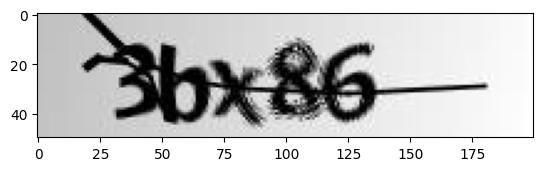

In [79]:
filename = '3bx86.png'
img1 = cv2.imread('../samples/'+ filename, cv2.IMREAD_GRAYSCALE)

# Remove .png
filename = filename[:-4]

plt.imshow(img1, cmap='gray')

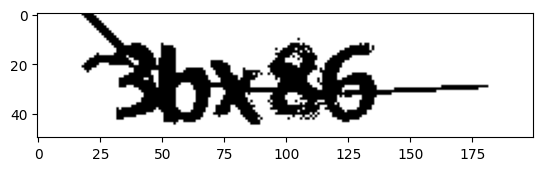

In [80]:
# images are in samples directory

img1_thr = cv2.threshold(img1, 127, 255, cv2.THRESH_BINARY)[1]

plt.imshow(img1_thr, cmap='gray')

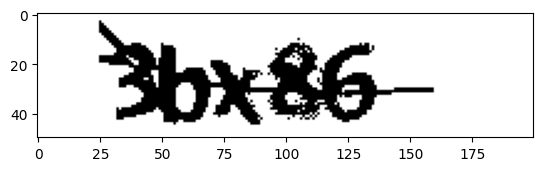

In [81]:
# remove useless stuff

img1_thr[:, 0:25] = 255

img1_thr[:, 160:] = 255

plt.imshow(img1_thr, cmap='gray')

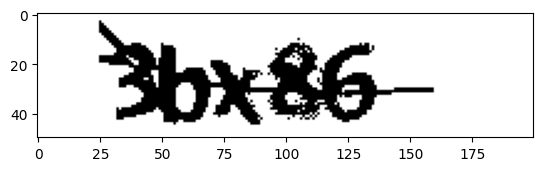

In [82]:
gauss_img1 = cv2.GaussianBlur(img1_thr, (1,1), 0)

plt.imshow(gauss_img1, cmap='gray')

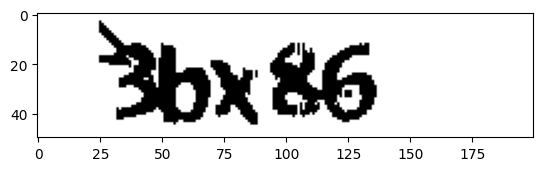

In [83]:
close_img1 = cv2.morphologyEx(gauss_img1, cv2.MORPH_CLOSE, np.ones((3,1), np.uint8))

#close_img1 = cv2.dilate(close_img1, np.ones((3,1), np.uint8), iterations = 1)

plt.imshow(close_img1, cmap='gray')

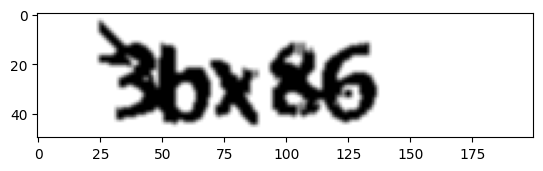

In [84]:
smooth = cv2.GaussianBlur(close_img1, (3,3), 0)

#sharp = cv2.addWeighted(smooth, 1.5, smooth, -0.5, 0)

plt.imshow(smooth, cmap='gray')

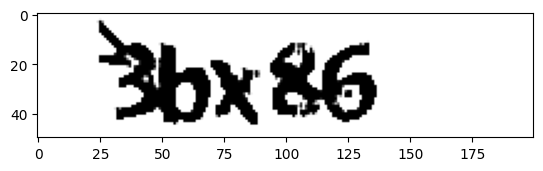

In [85]:
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpen = cv2.filter2D(smooth, -1, sharpen_kernel)

plt.imshow(sharpen, cmap='gray')


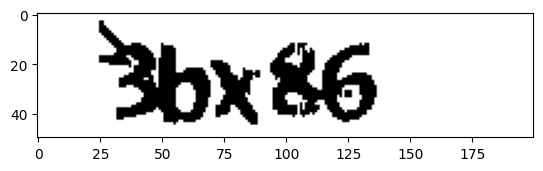

In [86]:
# thresholding
ret, thresh = cv2.threshold(sharpen, 185, 255, cv2.THRESH_BINARY)

plt.imshow(thresh, cmap='gray')

In [99]:
from PIL import Image
import torchvision.transforms as transforms

mser = cv2.MSER_create()

regions, rects = mser.detectRegions(thresh)

im2 = thresh.copy()

final_rects = []

for (x, y, w, h) in rects:
    if w > 135: continue
    elif w > 115:
        final_rects.append((x, y, w//5, h))
        final_rects.append((x + w//5, y, w//5, h))
        final_rects.append((x + 2 * w//5, y, w//5, h))
        final_rects.append((x + 3 * w//5, y, w//5, h))
        final_rects.append((x + 4 * w//5, y, w//5, h))
    elif w > 70:
        final_rects.append((x, y, w//4, h))
        final_rects.append((x + w//4, y, w//4, h))
        final_rects.append((x + 2 * w//4, y, w//4, h))
        final_rects.append((x + 3 * w//4, y, w//4, h))
    elif w > 50:
        final_rects.append((x, y, w//3, h))
        final_rects.append((x + w//3, y, w//3, h))
        final_rects.append((x + 2 * w//3, y, w//3, h))

    elif w > 35:
        final_rects.append((x, y, w//2, h))
        final_rects.append((x + w//2, y, w//2, h))
    else:
        final_rects.append((x, y, w, h))

# take the 5 biggest regions
final_rects = sorted(final_rects, key=lambda x: x[2] * x[3], reverse=True)[:5]

# Sort the rectangles by their x coordinate
final_rects = sorted(final_rects, key=lambda x: x[0])


# Create /samples_modified directory if it doesn't exist
if not os.path.exists('../samples_modified'):
    os.makedirs('../samples_modified')

transform = transforms.ToTensor()
X = []
y2 = []

for i, (x, y, w, h) in enumerate(final_rects):
    #cv2.rectangle(im2, (x, y), (x+w, y+h), color=(0, 255, 0), thickness=1)
    crop = im2[y:y+h, x:x+w]
    # Resize to 50x50
    crop = cv2.resize(crop, (50, 50))
    X.append(crop)
    y2.append(filename[i])

X = np.array(X, dtype=np.float32)
y2 = np.array(y2)

print(X.shape)
print(y2.shape)



(5, 50, 50)
(5,)


In [114]:
X /= 255.0

[]

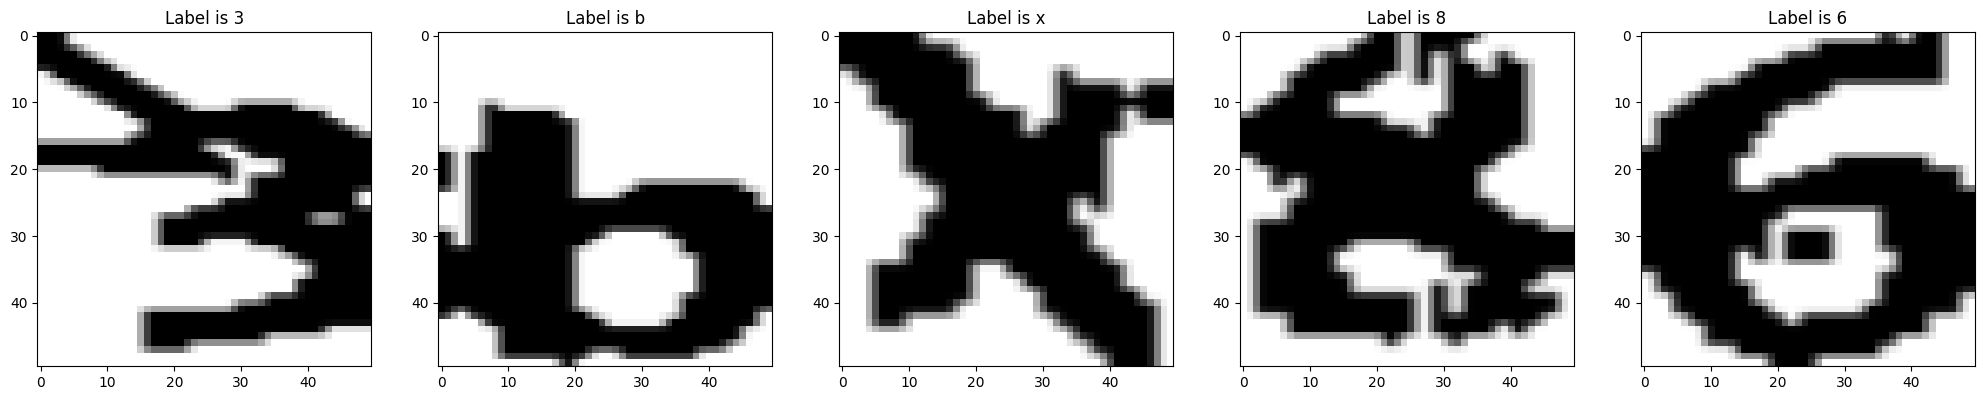

In [105]:
plt.figure(figsize = (25,25))
for i in range(5) :
    plt.subplot(1,5,i+1)
    plt.imshow(X[i], 'gray')
    plt.title('Label is ' + str(y2[i]))
plt.plot()

In [107]:
temp = set(y2)
for t in temp :
    print('Occurance count of ' + t + ' : ' + str(len(y2[y2 == t])))

Occurance count of x : 1
Occurance count of 8 : 1
Occurance count of b : 1
Occurance count of 3 : 1
Occurance count of 6 : 1
